### Importing required libraries

In [37]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.utils
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


#### Importing and exploring dataset

In [79]:
#Importing data as dataframe
data = pd.read_csv('AdSmartABdata.csv')

In [80]:
#Exploring the dataset
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


#### Reducing variance in the device make and browser column

In [81]:
#This code block associates all brands of a paricular phone together
data['device_make'] = data.device_make.str.replace(r'^.*Samsung.*$', r'Samsung')
data['device_make'] = data.device_make.str.replace(r'^.*Generic.*$', r'Generic')
data['device_make'] = data.device_make.str.replace(r'^.*Nokia.*$', r'Nokia')
data['device_make'] = data.device_make.str.replace(r'^.*LG.*$', r'LG')
data['device_make'] = data.device_make.str.replace(r'^.*Generic.*$', r'Generic')
data['device_make'] = data.device_make.str.replace(r'^.*Nokia.*$', r'Nokia')
data['device_make'] = data.device_make.str.replace(r'^.*Pixel.*$', r'Pixel')
data['device_make'] = data.device_make.str.replace(r'^.*OnePlus.*$', r'OnePlus')
data['device_make'] = data.device_make.str.replace(r'^.*CLT.*$', r'CLT')
data['device_make'] = data.device_make.str.replace(r'^.*VOG.*$', r'VOG')
data['device_make'] = data.device_make.str.replace(r'^.*ELE.*$', r'ELE')
data['device_make'] = data.device_make.str.replace(r'^.*HTC.*$', r'HTC')
data['device_make'] = data.device_make.str.replace(r'^.*XiaoMi.*$', r'XiaoMi')
data['device_make'] = data.device_make.str.replace(r'^.*Huawei.*$', r'Huawei')
data['device_make'] = data.device_make.str.replace(r'^.*LYA.*$', r'LYA')

In [82]:
#List of known device makes
phone_make = ['Samsung', 'Generic', 'Nokia', 'LG', 'Pixel', 'OnePlus', 'CLT', 'VOG', 'ELE', 'HTC', 'XiaoMi', 'HUAWEI']

In [83]:
#Rename the other brands not in phone_make Others
data['device_make'] = data['device_make'].apply(lambda x:x if x in phone_make else 'Others')

In [84]:
#Value counts of device make
data.device_make.value_counts().head(60)

Generic    4743
Samsung    2109
Others      786
Nokia       124
Pixel        77
OnePlus      60
LG           43
CLT          35
VOG          35
XiaoMi       28
HTC          20
ELE          17
Name: device_make, dtype: int64

In [88]:
#This code block associates all types of a paricular browser together
data['browser'] = data.browser.str.replace(r'^.*Chrome.*$', r'Chrome')
data['browser'] = data.browser.str.replace(r'^.*Opera.*$', r'Opera')
data['browser'] = data.browser.str.replace(r'^.*Safari.*$', r'Safari')

In [91]:
#List of known browser types
browser_type = ['Chrome', 'Samsung Internet', 'Facebook', 'Safari']

In [93]:
#Rename the other types not in browser_type list Others
data['browser'] = data['browser'].apply(lambda x:x if x in browser_type else 'Others')

In [94]:
#value counts of the browser
data.browser.value_counts().head()

Chrome              6097
Samsung Internet     824
Facebook             764
Safari               381
Others                11
Name: browser, dtype: int64

In [95]:
#Exploring the dataset
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic,6,Chrome,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic,6,Chrome,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,Others,6,Chrome,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic,6,Chrome,0,0


In [98]:
#Dropping the date column as a feature
data = data.drop(['date'],axis=1)
data.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,8,Generic,6,Chrome,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,10,Generic,6,Chrome,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2,Others,6,Chrome,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,15,Samsung,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,15,Generic,6,Chrome,0,0


#### Machine Learning

In [99]:
#Viewing categorical features in dataset
categorical_features = [x for x in data.columns if data[x].dtype == 'object']
print(categorical_features)


['auction_id', 'experiment', 'device_make', 'browser']


In [100]:
#Labelling categorical features with LabelEncoder
from sklearn.preprocessing import LabelEncoder
#New variable
var_mod = [x for x in categorical_features if x not in ['auction_id']]
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [101]:
#Explorind dataset
data.head()

,auction_id,experiment,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,1,8,2,6,0,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,1,10,2,6,0,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,7,6,0,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,0,15,9,6,1,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,0,15,2,6,0,0,0


In [126]:
#Segementing data into features and target variables
importantcols=[x for x in data.columns if x not in ['auction_id','yes']]
print(importantcols)
y = data[["yes"]]
X = data[importantcols]

['experiment', 'hour', 'device_make', 'platform_os', 'browser', 'no']


In [128]:
#Splitting into test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10)

In [130]:
#Spliting train into validation and train
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.20)

### Training ML model using five fold validation

#### Logistic Regression

In [131]:
#Using KFold Validation and Logistic regression algorithm 
kfold = model_selection.KFold(n_splits=5)
model_kfold = LogisticRegression()
model_kfold.fit(X_train, y_train)
results_kfold = model_selection.cross_val_score(model_kfold, X_train, y_train, cv=kfold)
#Cross validation score
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 92.86%


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model

In [137]:
#Predicting with the validation data
pred = model_kfold.predict(X_valid)
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [138]:
from sklearn.metrics import accuracy_score
#Accuracy score for model
print("Accuracy for model: %.2f" % (accuracy_score(y_valid, pred) * 100))

Accuracy for model: 92.69


Feature: 0, Score: 0.17738
Feature: 1, Score: 0.00788
Feature: 2, Score: 0.02200
Feature: 3, Score: -0.03762
Feature: 4, Score: -0.01768
Feature: 5, Score: -2.52349


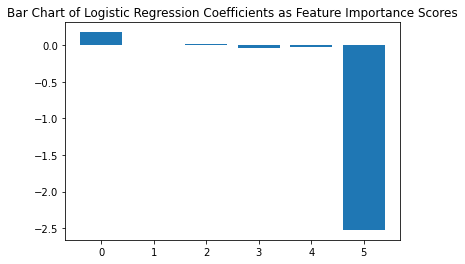

In [146]:
#calulating the feature importance
importance = model_kfold.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Bar Chart of Logistic Regression Coefficients as Feature Importance Scores')
plt.show()

#### Decision Tree

In [147]:
#Using KFold Validation and Decision Tree Classifier algorithm 
from sklearn.tree import DecisionTreeClassifier

kfold = model_selection.KFold(n_splits=5)
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
results_kfold = model_selection.cross_val_score(dtree, X_train, y_train, cv=kfold)
#Cross validation score
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 





Accuracy: 92.35%


In [148]:
#predicting with the validation data
pred_tree = dtree.predict(X_valid)
pred_tree

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [150]:
#model accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_valid, pred_tree) * 100))

Accuracy for model: 92.18


In [157]:
#caluclating the feature importance
importance = dtree.feature_importances_
importance

array([0.10586101, 0.45677397, 0.2583287 , 0.02375021, 0.1031661 ,
       0.05212002])

Feature: 0, Score: 0.10586
Feature: 1, Score: 0.45677
Feature: 2, Score: 0.25833
Feature: 3, Score: 0.02375
Feature: 4, Score: 0.10317
Feature: 5, Score: 0.05212


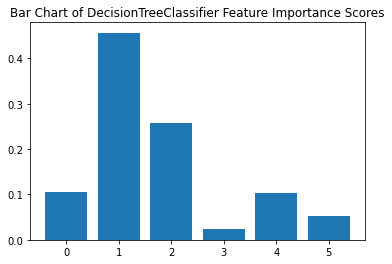

In [153]:
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Bar Chart of DecisionTreeClassifier Feature Importance Scores')
plt.show()

#### XGBOOST

In [134]:
import xgboost as xgb
#apply kfold validation and XGBoost algorithm
kfold = model_selection.KFold(n_splits=5)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
results_kfold = model_selection.cross_val_score(xgb_model, X_train, y_train, cv=kfold)
#cross validation score
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 92.86%


In [154]:
#predicting with the validation data
pred_xgb = xgb_model.predict(X_valid)
pred_xgb

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [155]:
#model accuracy score
print("Accuracy for model: %.2f" % (accuracy_score(y_valid, pred_xgb) * 100))

Accuracy for model: 92.69


In [156]:
#feature importance: the hour and device make 
importance_xgb = xgb_model.feature_importances_
importance_xgb

array([0.08812093, 0.09386168, 0.12427052, 0.15400538, 0.11417585,
       0.42556557], dtype=float32)

Feature: 0, Score: 0.08812
Feature: 1, Score: 0.09386
Feature: 2, Score: 0.12427
Feature: 3, Score: 0.15401
Feature: 4, Score: 0.11418
Feature: 5, Score: 0.42557


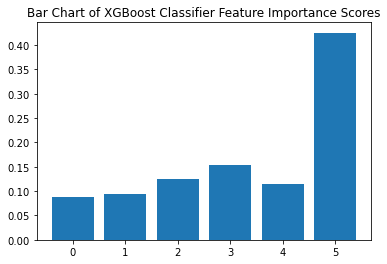

In [158]:
for i,v in enumerate(importance_xgb):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_xgb))], importance_xgb)
plt.title('Bar Chart of XGBoost Classifier Feature Importance Scores')
plt.show()

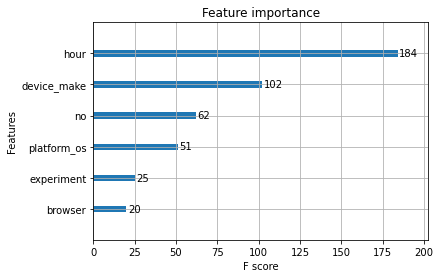

In [136]:
from xgboost import plot_importance
#plot feature importance
plot_importance(xgb_model)
plt.show()